<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/model_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = "/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/data/"
model_path = '/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import Libs

In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [3]:
data = pd.read_pickle(data_path + 'data_cont_cat_lb.pkl')
features = list(np.load(data_path + 'features.pkl.npy'))
print('data shape: ', data.shape)
print('features lenght: ', len(features))

data shape:  (48813, 39)
features lenght:  31


# Model Defintion

## Hyperparameter Tuning

In [0]:
data = data[features + ['target']]
X, y = data.drop(columns = 'target'), data['target']

In [0]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, log_loss

def objective(params):
  local_params = {
      'objective': 'binary',
      'metric': 'binary_logloss',
      'save_binary': True,
      'bagging_freq': 1,
      'bagging_seed': 2**7,
      'learning_rate': '{:.3f}'.format(params['learning_rate']),
      'num_leaves': int(params['num_leaves']),
      'min_data_in_leaf': int(params['min_data_in_leaf']),
      'max_depth': int(params['max_depth']),
      'bagging_fraction': '{:.3f}'.format(params['bagging_fraction']),
  }
  d_train = lgb.Dataset(X, label = y)
  cv_results = lgb.cv(local_params, d_train, num_boost_round = 2000, nfold = 5, 
                    verbose_eval = 0, early_stopping_rounds = 10)
  print('Best num_boost_round: {}'.format(len(cv_results['binary_logloss-mean'])))
  print("Best CV score {:.3f} params {}".format(cv_results['binary_logloss-mean'][-1], local_params))
  return cv_results['binary_logloss-mean'][-1]

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'num_leaves': hp.quniform('num_leaves', 7, 4095, 2),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 20, 500, 5),
    'max_depth': hp.quniform('max_depth', 2, 63, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, 1),
}

best = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 100)

Best num_boost_round: 65
Best CV score 0.289 params {'objective': 'binary', 'metric': 'binary_logloss', 'save_binary': True, 'bagging_freq': 1, 'bagging_seed': 128, 'learning_rate': '0.141', 'num_leaves': 1364, 'min_data_in_leaf': 225, 'max_depth': 41, 'bagging_fraction': '0.727'}
Best num_boost_round: 31
Best CV score 0.299 params {'objective': 'binary', 'metric': 'binary_logloss', 'save_binary': True, 'bagging_freq': 1, 'bagging_seed': 128, 'learning_rate': '0.220', 'num_leaves': 3502, 'min_data_in_leaf': 310, 'max_depth': 59, 'bagging_fraction': '0.473'}
Best num_boost_round: 397
Best CV score 0.286 params {'objective': 'binary', 'metric': 'binary_logloss', 'save_binary': True, 'bagging_freq': 1, 'bagging_seed': 128, 'learning_rate': '0.035', 'num_leaves': 3798, 'min_data_in_leaf': 235, 'max_depth': 10, 'bagging_fraction': '0.622'}
Best num_boost_round: 26
Best CV score 0.289 params {'objective': 'binary', 'metric': 'binary_logloss', 'save_binary': True, 'bagging_freq': 1, 'bagging_

In [0]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'bagging_fraction': 0.9950862015751782, 'learning_rate': 0.04588724059954422, 'max_depth': 8.0, 'min_data_in_leaf': 20.0, 'num_leaves': 1980.0}


# Model Training

In [4]:
data = data[features + ['target']]
X, y = data.drop(columns = 'target'), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
print('---Train size----')
print(X_train.shape)
print(y_train.shape)
print('---Validation size----')
print(X_val.shape)
print(y_val.shape)
print('---Test size----')
print(X_test.shape)
print(y_test.shape)

---Train size----
(29287, 31)
(29287,)
---Validation size----
(9763, 31)
(9763,)
---Test size----
(9763, 31)
(9763,)


In [0]:
lgbm_params = {
      'objective': 'binary',
      'metric': 'binary_logloss',
      'save_binary': True,
      'bagging_freq': 1,
      'bagging_seed': 2**7,
      'learning_rate': 0.045,
      'num_leaves': 1980,
      'min_data_in_leaf': 20,
      'max_depth': 8,
      'bagging_fraction':  0.995,
}

Training until validation scores don't improve for 50 rounds.
[10]	training's binary_logloss: 0.416259	valid_1's binary_logloss: 0.418255
[20]	training's binary_logloss: 0.355118	valid_1's binary_logloss: 0.360291
[30]	training's binary_logloss: 0.32064	valid_1's binary_logloss: 0.32897
[40]	training's binary_logloss: 0.29941	valid_1's binary_logloss: 0.310427
[50]	training's binary_logloss: 0.285635	valid_1's binary_logloss: 0.299311
[60]	training's binary_logloss: 0.276506	valid_1's binary_logloss: 0.292463
[70]	training's binary_logloss: 0.269264	valid_1's binary_logloss: 0.288065
[80]	training's binary_logloss: 0.263397	valid_1's binary_logloss: 0.284565
[90]	training's binary_logloss: 0.258547	valid_1's binary_logloss: 0.281632
[100]	training's binary_logloss: 0.254454	valid_1's binary_logloss: 0.279603
[110]	training's binary_logloss: 0.250243	valid_1's binary_logloss: 0.278362
[120]	training's binary_logloss: 0.245352	valid_1's binary_logloss: 0.27711
[130]	training's binary_log

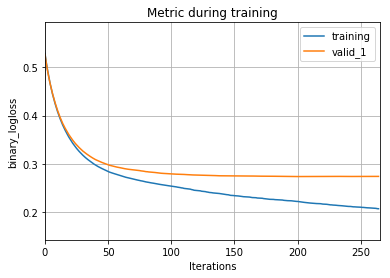

In [8]:
d_train = lgb.Dataset(X_train, y_train)
d_val = lgb.Dataset(X_val, y_val)
n_estimator = 2000
evals_result = {}
gbm_model = lgb.LGBMClassifier(
        n_estimators = n_estimator,
        **lgbm_params,
)
gbm_model.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_val, y_val)],
        verbose = 10, 
        early_stopping_rounds = 50)
ax = lgb.plot_metric(gbm_model.evals_result_)
plt.show()

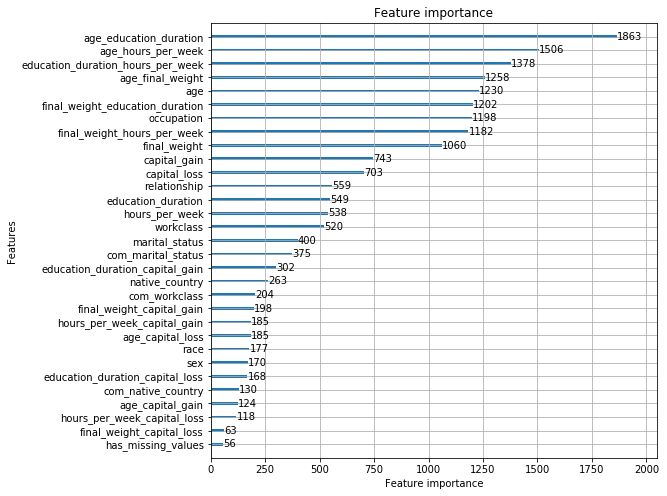

In [9]:
axis = lgb.plot_importance(gbm_model, max_num_features = 31, figsize = (8, 8))
plt.show()

# Model Evaluation

In [10]:
y_train_hat = gbm_model.predict(X_train)
y_test_hat = gbm_model.predict(X_test)

tr_acc = accuracy_score(y_train, y_train_hat)
tr_f1 = f1_score(y_train, y_train_hat)
tr_auc = roc_auc_score(y_train, y_train_hat)

test_acc = accuracy_score(y_test, y_test_hat)
test_f1 = f1_score(y_test, y_test_hat)
test_auc = roc_auc_score(y_test, y_test_hat)
print('------train-----------')
print('accuracy_score: ', tr_acc)
print('f1_score: ', tr_f1)
print('roc_auc_score: ', tr_auc)
print('------test-------------')
print('accuracy_score: ', test_acc)
print('f1_score: ', test_f1)
print('roc_auc_score: ', test_auc)

------train-----------
accuracy_score:  0.9014921296138219
f1_score:  0.7776835940510133
roc_auc_score:  0.8399030640778926
------test-------------
accuracy_score:  0.8700194612311789
f1_score:  0.7155346334902487
roc_auc_score:  0.8018318712205094


[[6898  477]
 [ 792 1596]]


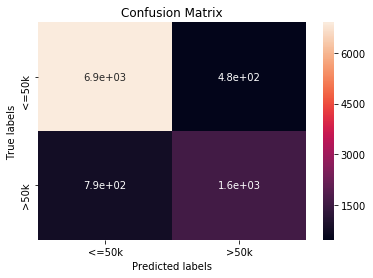

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = [0, 1]
cm = confusion_matrix(y_test, y_test_hat, labels)
print(cm)
ax =  plt.subplot()
sns.heatmap(cm, annot = True, ax = ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['<=50k', '>50k']); 
ax.yaxis.set_ticklabels(['<=50k', '>50k']);

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7375
           1       0.77      0.67      0.72      2388

    accuracy                           0.87      9763
   macro avg       0.83      0.80      0.82      9763
weighted avg       0.87      0.87      0.87      9763



# Model Saving

In [14]:
gbm_model.booster_.save_model(model_path + 'lgbm_model.txt', num_iteration = gbm_model.booster_.best_iteration)